# Prediction of member type based on biking trip data

This is a notebook to study a biking data set obtained from
https://s3.amazonaws.com/capitalbikeshare-data/index.html .

The exercise was suggested on 
https://www.analyticsvidhya.com/blog/2018/05/24-ultimate-data-science-projects-to-boost-your-knowledge-and-skills/
under the title 'Trip history data set'.

Author of the notebook: Gustav Baardsen <br>
Date of first version: February 2019



In [1]:
import numpy as np
import tensorflow as tf

import analysis
import keras.utils.np_utils as ks_utils

from sklearn.linear_model import LinearRegression
from analysis import BikingData

Using TensorFlow backend.


In [2]:
data_file = '2017Q1-capitalbikeshare-tripdata.csv'
data = BikingData(data_file)
data.print_categories()


Categories in the data:

  Duration
  Start station number
  End station number
  Bike number
  Member type



### Reading and preparation of data set
The data is read into a DataFrame object of the pandas library.

-  Assuming that the duration of the trip is more important than the start and end dates, the dates were dropped out from the data set. Because the data set contains IDs of the start and end stations, the station names are superfluous, and were therefore neglected.

-  Each time the DataFrame object is created, the samples of the data set are shuffled randomly using the function utils.shuffle() from the Scikit-Learn library.

-  Bike number and member type are converted to 'category' using the function astype() of the DataFrame class.

### Prediction task

Given start station, end station, bike number, and duration of the trip, the task is to predict the type of member. The member type is either 'Member' or 'Casual'.

In [3]:
input_data  = data.get_array()[:, :4]
output_data = data.get_array()[:, 4:5]

In [4]:
# Count the number of 'Member' and 'Casual'.
# 'Casual' is coded as 0 and 'Member' as 1.
n_total   = output_data.shape[0]
n_members = np.sum(output_data)
n_casual  = n_total - n_members
print('Number of members:', n_members, 
      '\nNumber of non-members:', n_casual)
print('Ratio non-members of total:', 
      '{:f}'.format(float(n_casual) / n_total))

Number of members: 528434 
Number of non-members: 118076
Ratio non-members of total: 0.182636


### Members vs. non-memebers

Here we can see that most of the data samples are associated with members. Still, the ratio of non-members is approximately 18 %.

Let us compute the average trip distance of members and non-members.

In [5]:
distances = data.get_array()[:, 0]
members = data.get_array()[:, -1].astype(bool)
casual  = (np.ones(n_total, dtype = int) - 
           members).astype(bool)

mean_distance_members = np.mean(distances[members])
mean_distance_casual = np.mean(distances[casual])
mean_distance_all = np.mean(distances)

print('Mean distance for members:', mean_distance_members)
print('Mead distance for non-members:', mean_distance_casual)
print('Mean distance for all bikers:', mean_distance_all)

Mean distance for members: 689.8324956380551
Mead distance for non-members: 2445.304879907856
Mean distance for all bikers: 1010.4449490340444


### Mean distances of members and non-memebers

As seen above, in average, members do shorter trips than non-members. Knowing that 'Casual' is coded as 0 and 'Member' as 1, this is in agreement with the negative correlation between distance and member type seen in the printout of the covariance matrix below. 


Covariance matrix for the data:

1.0000000000000018 -0.01155430441831321 -0.015247974552680977 0.0017750658223915378 -0.3249887188358131 
-0.01155430441831321 0.9999999999999987 0.5151015530604809 0.015366824745471894 0.052161192985006856 
-0.015247974552680977 0.5151015530604809 1.0000000000000013 0.015207530558443446 0.05869457483015617 
0.0017750658223915378 0.015366824745471894 0.015207530558443446 1.0 0.006819389262299627 
-0.3249887188358131 0.052161192985006856 0.05869457483015617 0.006819389262299627 1.0000000000000133 



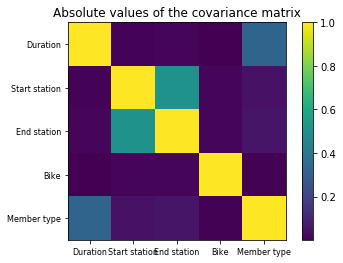

In [6]:
# Plot the covariance matrix between the variables
analysis.plot_covariance(data.get_array())

### What the covariance matrix tells us...

According to the covariance matrix of the five variables, the start and end stations are most clearly correlated. This is of course expected. In addition, one can see a correlation between the duration of the bike trip and the type of member. As we found above, in average, non-members go on longer biking trips than members do.

### Using the data in learning methods

When using a neural network for a prediction task, it is common to divide the total data set into partitions for training, development, and testing. This we will do below.

Furthermore, we chose to represent the member data of each sample using two integers. For example, if the sample corresponds to a 'Member', then the member data of that sample is [0, 1], whereas a 'Casual' is denoted by [1, 0].

In [7]:
output_data_c = ks_utils.to_categorical(output_data,
                                        num_classes = 2)

In [8]:
# Partition the data set into training, development,
# and test sets. The input and output data are also
# normalized.
input_train, input_dev, input_test, \
    output_train, output_dev, output_test = \
        analysis.get_train_test_dev_sets(input_data,
                                        output_data_c)


Size of training set:     517208
Size of development set:  128655
Size of test set:         647 



### Linear regression

As the most straightforward prediction approach, we classify biking data samples using linear regression and a least-squares error functional. This is done using the LinearRegression class from Scikit-Learn.

In the linear regression, each member type is represented by a single integer: 0 for 'Casual' and 1 for 'Member'. A linear-regression prediction with a value larger than 0.5 is classified as 'Member' and the rest are classified as 'Casual'.

The training set is used for the linear fitting, whereas the development set is used to test the prediction based on linear regression.

In [9]:
regressor = LinearRegression()
regressor.fit(input_train,
            output_train[:, 1])
output_linreg = regressor.predict(input_dev)
    
# Accuracy of prediction
accuracy = analysis.classify_from_regression(output_linreg,
                                            output_dev[:, 1])
print('\nClassification accuracy of linear regression:',
        '{:f}'.format(accuracy))


Classification accuracy of linear regression: 0.828946


### The prediction power of the linear regressor

Here the linear-regression classifier predicts correctly for approximately 82 % of the samples. 

Above we found that the ratio of samples with member type 'Casual' is around 18 %. Assuming the same distribution of 'Member' vs. 'Casual' in the development set, a performance equally good as the linear-regression classifier would have been obtained by just assuming that all samples are of type 'Member'.

In fact, that is also what we see in the analysis below: In the linear-regression classification, only around 1 % of the samples are predicted as being non-member. This is far from the true ratio, which is around 18 %. Also, only about 7 % of the real non-members were classified as non-member.

Therefore, the classification accuracy of the linear regressor is not good, and we would like to find a better predictor.

In [10]:
predicted_classes = (output_linreg > 0.5).astype(int)

n_dev    = output_dev[:, 1].shape[0]
n_pred_member = np.count_nonzero(predicted_classes)
print('\nNumber of samples predicted as member:',
     n_pred_member)
print('Number of samples predicted as non-member:',
      n_dev - n_pred_member)

n_dev_member = np.sum(output_dev[:, 1])
ratio_nonmember_dev = \
    float(n_dev - n_dev_member) / float(n_dev)
print('\nTrue ratio (non-members / all):',
     '{:f}'.format(ratio_nonmember_dev))

ratio_nonmember_pred = \
    float(n_dev - n_pred_member) / float(n_dev)
print('Predicted ratio (non-members / all):',
    '{:f}'.format(ratio_nonmember_pred))



ratio_member = \
    analysis.ratio_correctly_predicted_true(predicted_classes,
                                           output_dev[:, 1])
print('\nRatio of members that were correctly predicted as members:',
     '{:f}'.format(ratio_member))

ratio_nonmember = \
    analysis.ratio_correctly_predicted_false(predicted_classes,
                                            output_dev[:, 1])
print('\nRatio of non-members that were correctly predicted as non-member:',
     '{:f}'.format(ratio_nonmember), 
     '\n')


Number of samples predicted as member: 126855
Number of samples predicted as non-member: 1800

True ratio (non-members / all): 0.182371
Predicted ratio (non-members / all): 0.013991

Ratio of members that were correctly predicted as members: 0.998365

Ratio of non-members that were correctly predicted as non-member: 0.069386 



### A neural network for the classification task

Because the linear regressor did not perform satisfactorily, let us try solving the classification problem using a neural network. 

We construct the neural network using the libraries Tensorflow and Keras.

-  The neural network is constructed by $N-1$ layers with a RelU activation function and a last layer with a Softmax activation.
-  The loss function is losses.softmax_cross_entropy from Tensorflow.
-  Adam's algorithm is used for the optimization.

The softmax activation in the last layer was chosen because it can be interpreted as giving probabilities, which is suitable for the classification task we have, with two possible output classes.

In [11]:
# Create a neural-network predictor object
analyser = analysis.NNPredictor(input_train,
                               input_dev,
                               input_test,
                               output_train,
                               output_dev,
                               output_test)

First, we test a neural network in with four layers, in which the three first contains four neurons each. The batch size is chosen to be 500, which is quite large, and we start by using no regularization. 

In [12]:
opt_algorithm   = 'adam'
loss_function   = tf.losses.softmax_cross_entropy
error_metrics   = ['accuracy']
n_per_layer     = [4, 4, 4]
n_iterations    = 4
n_batch         = 500
reg_parameters  = [0.0, 0.0]
    
print('Next, a neural network is trained...')
analyser.train_network(optimization = opt_algorithm,
                        loss = loss_function,
                        metrics = error_metrics,
                        n_neurons = n_per_layer,
                        n_mainloop = n_iterations,
                        batch_size = n_batch,
                        reg_params = reg_parameters)

Next, a neural network is trained...
Epoch 1/4
517208/517208 [==============================] - 3s 5us/step - loss: 0.5216 - acc: 0.7948
Epoch 2/4
517208/517208 [==============================] - 2s 4us/step - loss: 0.4539 - acc: 0.8477
Epoch 3/4
517208/517208 [==============================] - 2s 4us/step - loss: 0.4395 - acc: 0.8800
Epoch 4/4
517208/517208 [==============================] - 3s 5us/step - loss: 0.4322 - acc: 0.8826


### Validation

Let us test the performance of this neural network on the development data set.

128655/128655 [==============================] - 3s 24us/step

Error in the development set:

Loss: 0.4301892451398469
Accuracy: 0.8828339357204866 



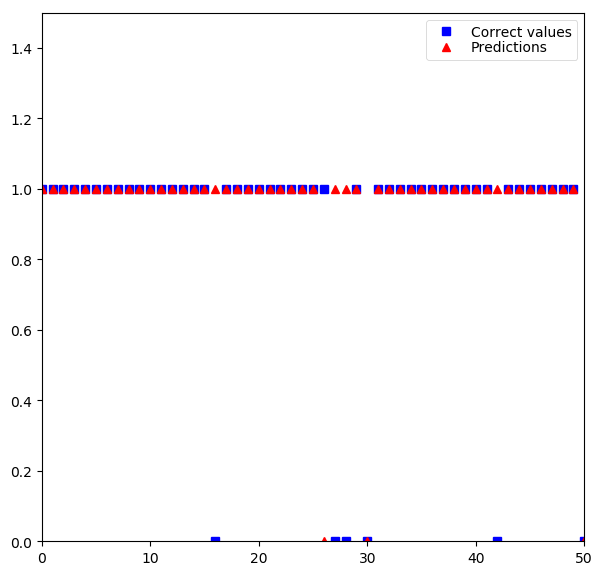

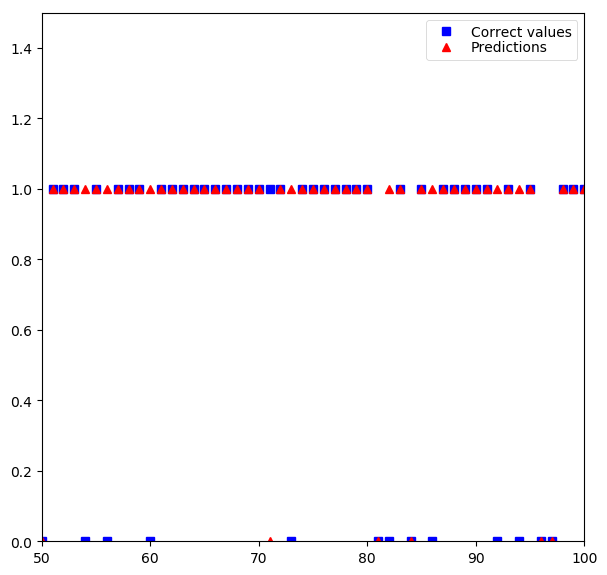

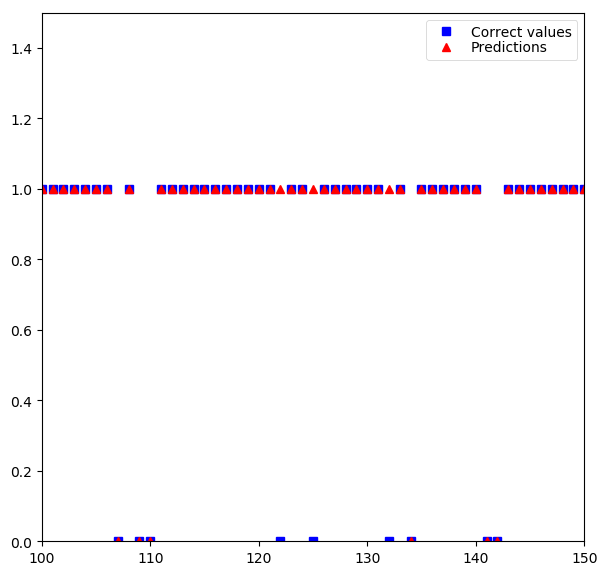

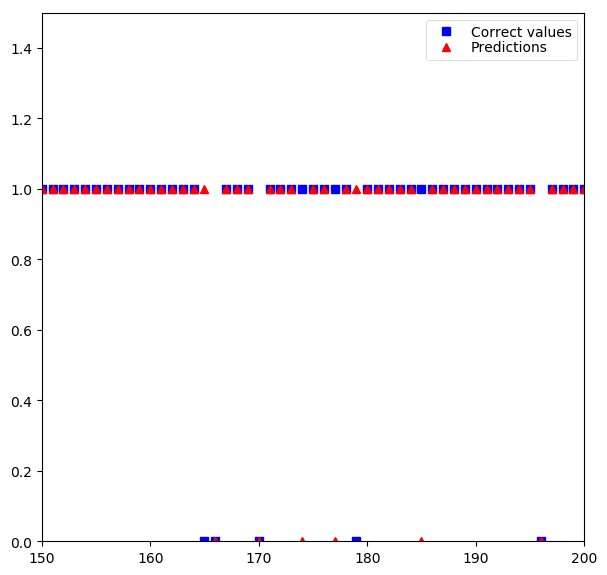

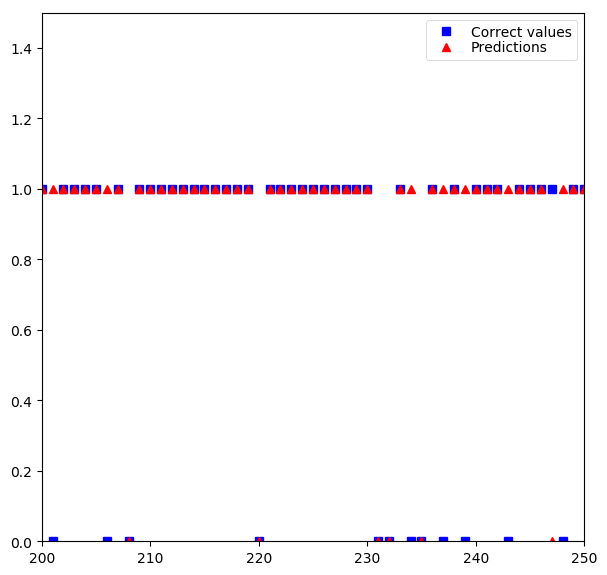

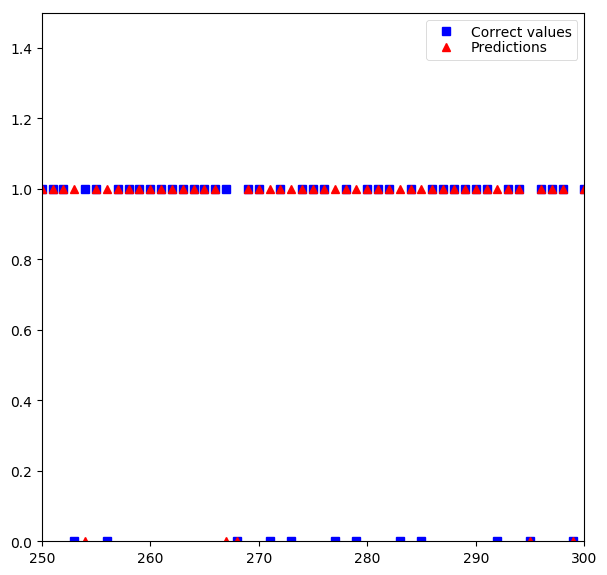

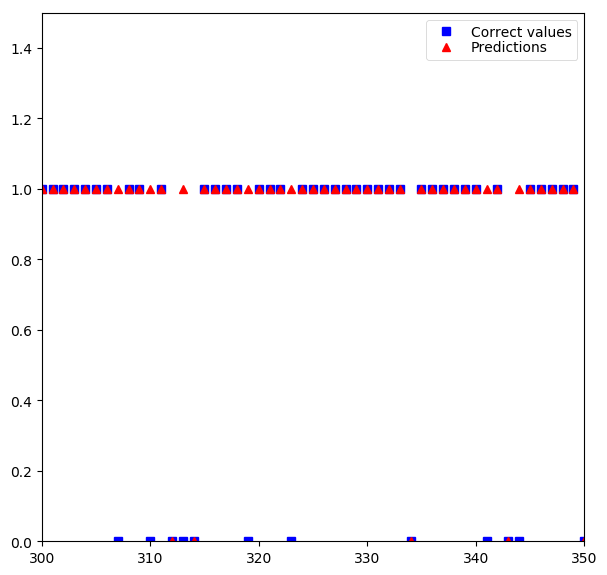

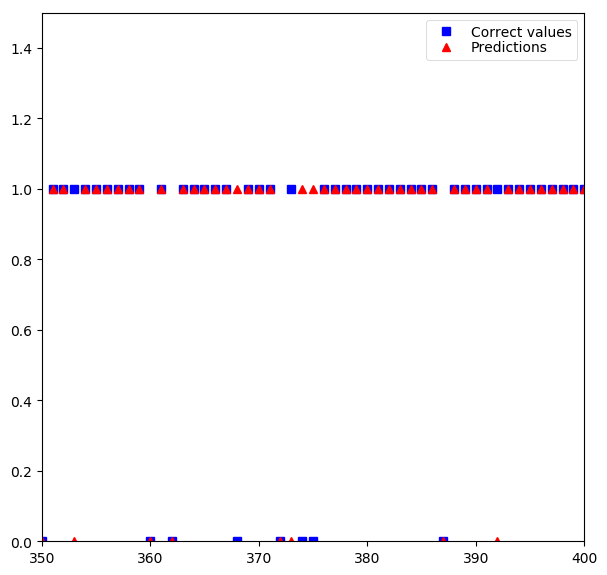

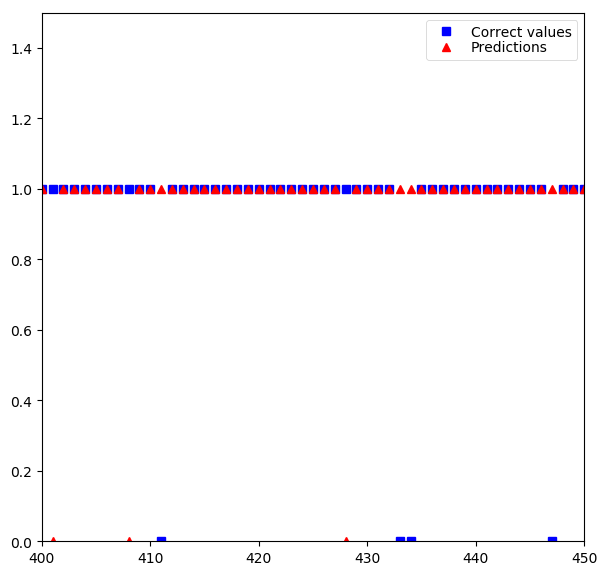

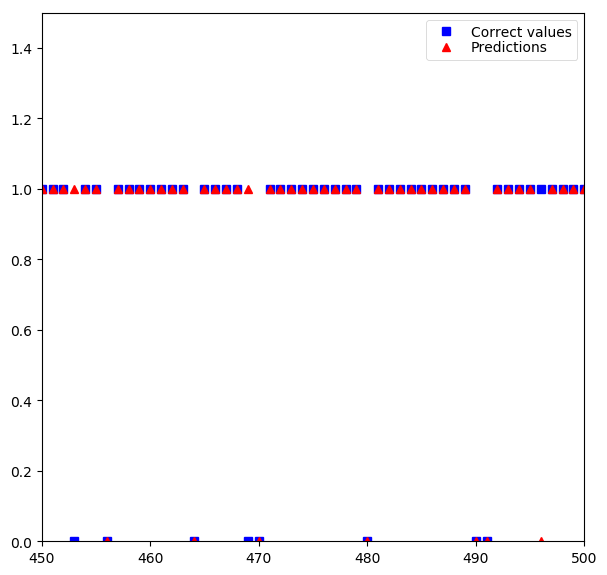

In [13]:
analyser.validate(analyser.in_dev,
                 analyser.out_dev)

### Analysis of the first neural-network results

The classification accuracy has now improved to 88 %. This is clearly better than what would have been obtained by assuming that all samples are associated with a member.

To understand the performance of the neural network better, we analyse the classification result of the neural network in a similar way as we did above for the linear regressor.

In [14]:
# Array containing ones for 'Member' and zeros for 'Casual'
predicted_classes = \
    analyser.get_predictions(analyser.in_dev)
    
n_dev    = output_dev[:, 1].shape[0]
n_pred_member = np.count_nonzero(predicted_classes)
print('\nNumber of samples predicted as member:',
     n_pred_member)
print('Number of samples predicted as non-member:',
      n_dev - n_pred_member)

n_dev_member = np.sum(output_dev[:, 1])
ratio_nonmember_dev = \
    float(n_dev - n_dev_member) / float(n_dev)
print('\nTrue ratio (non-members / all):',
     '{:f}'.format(ratio_nonmember_dev))

ratio_nonmember_pred = \
    float(n_dev - n_pred_member) / float(n_dev)
print('Predicted ratio (non-members / all):',
    '{:f}'.format(ratio_nonmember_pred))



ratio_member = \
    analysis.ratio_correctly_predicted_true(predicted_classes,
                                           output_dev[:, 1])
print('\nRatio of members that were correctly predicted as members:',
     '{:f}'.format(ratio_member))

ratio_nonmember = \
    analysis.ratio_correctly_predicted_false(predicted_classes,
                                            output_dev[:, 1])
print('\nRatio of non-members that were correctly predicted as non-member:',
     '{:f}'.format(ratio_nonmember), 
     '\n')


Number of samples predicted as member: 114124
Number of samples predicted as non-member: 14531

True ratio (non-members / all): 0.182371
Predicted ratio (non-members / all): 0.112945

Ratio of members that were correctly predicted as members: 0.970806

Ratio of non-members that were correctly predicted as non-member: 0.488429 



### Analysis of the first neural-network results continues...

These results look considerably better than what was obtained with the linear regressor. Now 49 % of real non-members are correctly classified as non-members. The error in the prediction of real members is slightly worse, but the ratio of members that were correctly predicted as members is still 97 %.

Because the classification accuracy on the development set is almost equal to the accuracy on the test set, overfitting does not seem to be a big problem. 

When using the test set, the classification accuracy is almost unchanged:

647/647 [==============================] - 0s 28us/step

Error in the development set:

Loss: 0.4312851674037149
Accuracy: 0.8809891810188706 



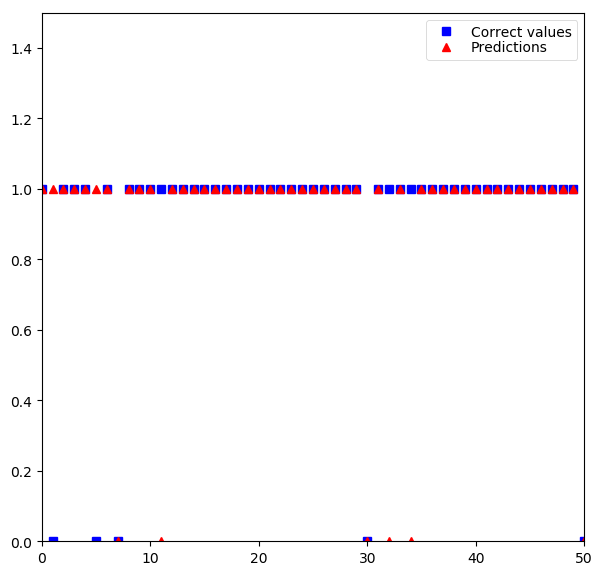

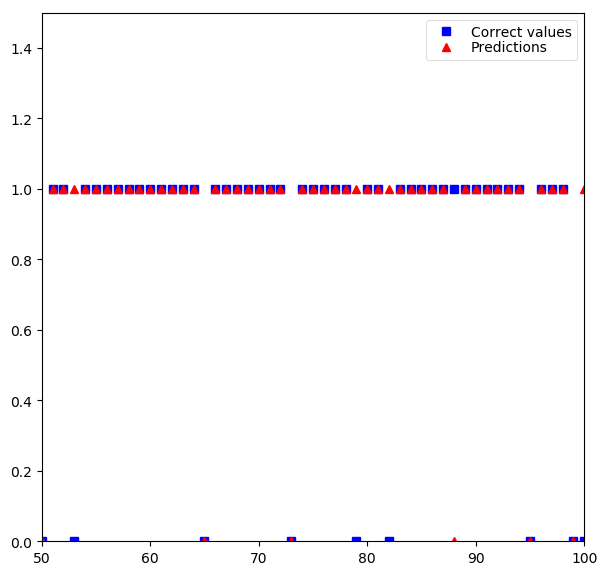

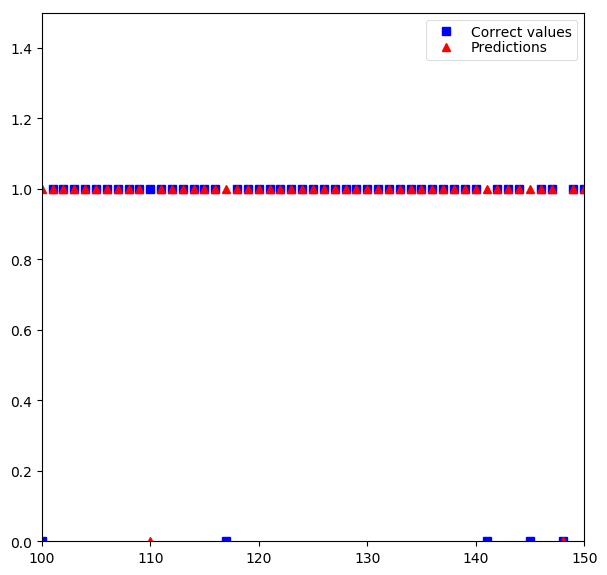

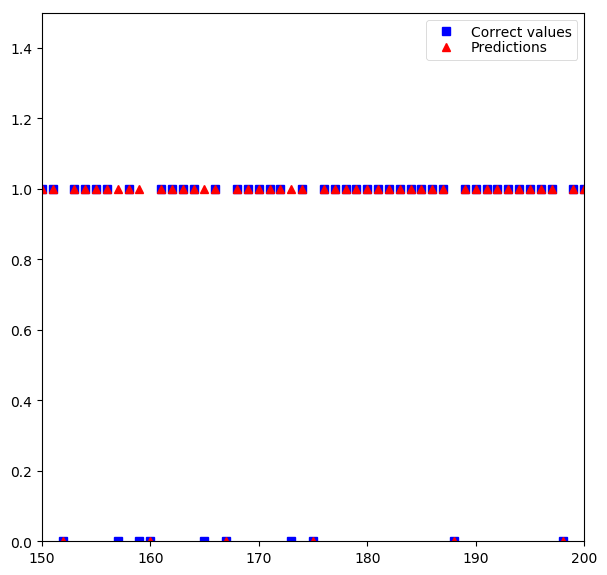

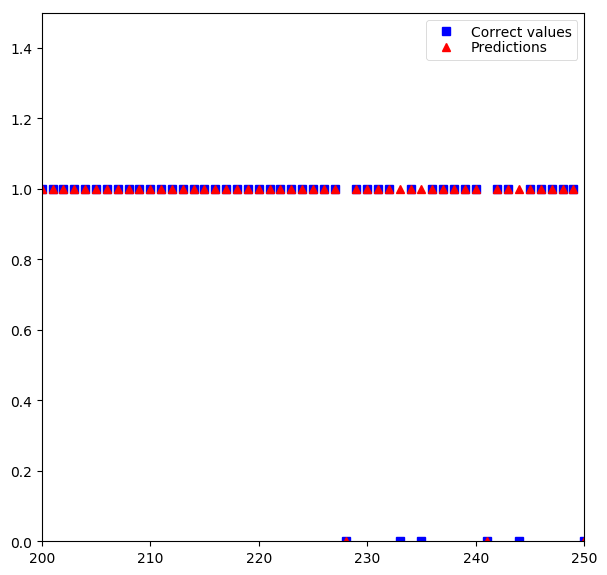

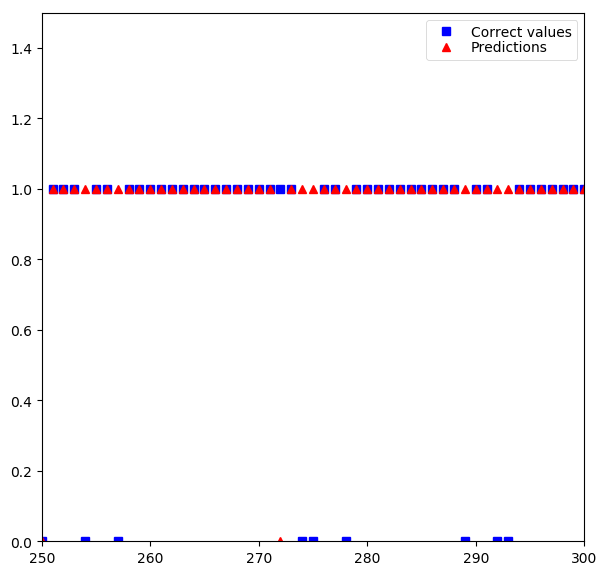

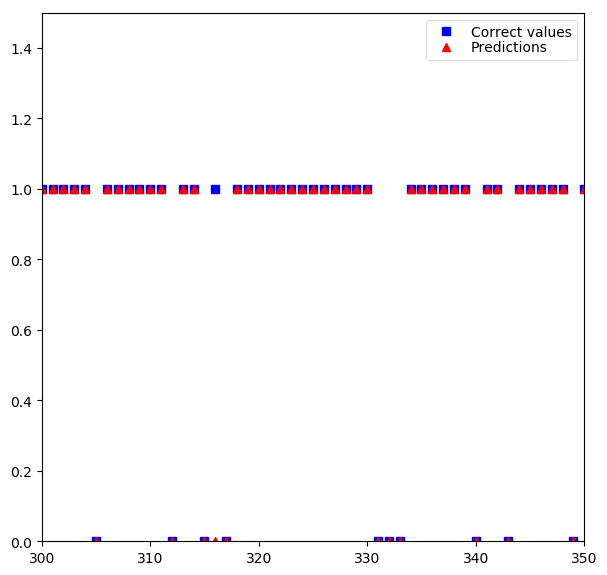

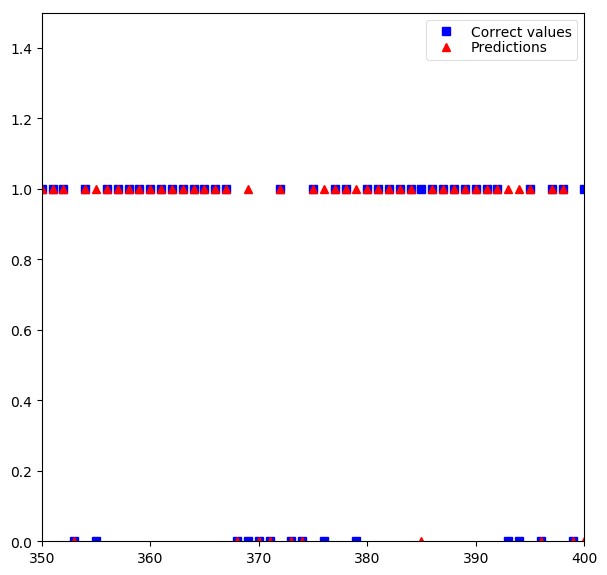

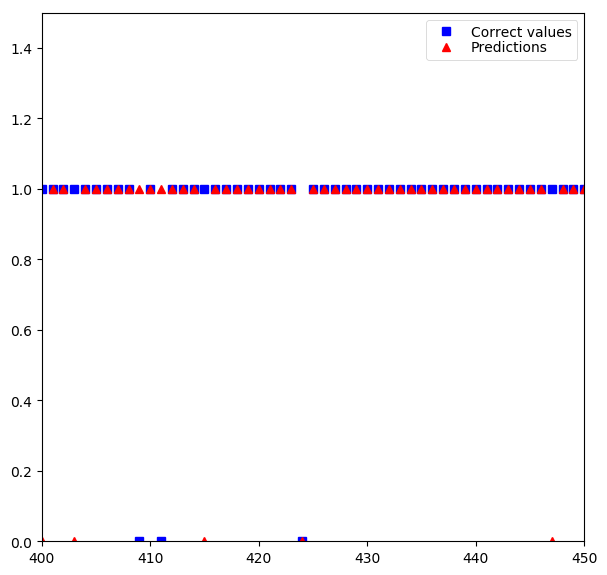

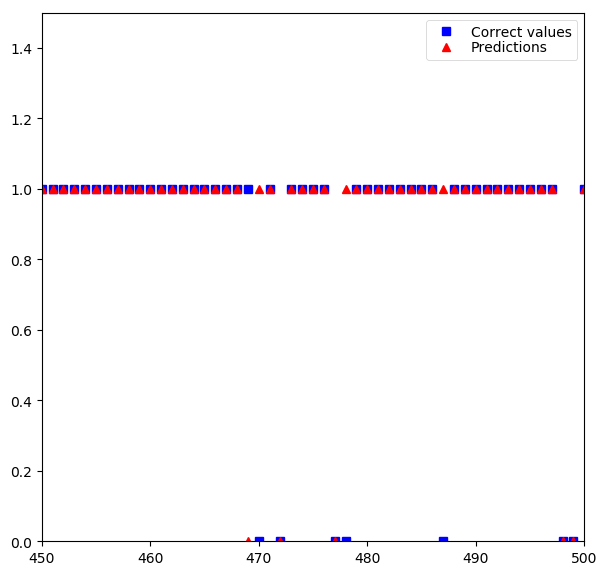

In [16]:
analyser.validate(analyser.in_test,
                 analyser.out_test)